# Intro

Neural style transfer is the problem of generating a new image which has the content from one image and the style(s) from another. It is ill-posed; for style transfer there is no single correct output. Also, we can't readily apply traditional supervised learning algorithms. It would require a pair of input images—both an original image and an artistic representation of that original image, which is not practical. 

### A Neural Algorithm of Artistic Style

Gatys et al. published one of the first seminal works to use neural networks to solve this problem. 
The most important idea here is "representations of content and style in the Convolutional Neural Network are separable". 
They use the following definitions to remove ambiguity from the ill-posed problem.

1. Two images are similar in content if their high-level features as extracted by a trained classifier are close in Euclidian distance.
2. Two images are similar in style if their low-level features as extracted by a trained classifier share the same statistics or, more concretely, if the difference between the features’ Gram matrices has a small Frobenius norm.

The objective function is the weighted sum of style and content distance. The minima of the objective function found using gradient descent corresponds to the desired stylized image.  


The algorithm does have a few limitations 
1. prohibitively expensive espectially for high resolution images - task is modelled as an optimization problem, requiring hundreds or thousands of iterations.   
2. haven't provided evidence for  multi-style transfer extns

Despite its flaws, the algorithm is very flexible. Therefore, I decided to first explore this method to solve the assignment.


##### Modified Algorithm

Given content image $\vec{p}$ and style image $\vec{a}$, the loss function to minimise was

$$\mathcal{L}_{\text {total }}(\vec{p}, \vec{a}, \vec{x})=\alpha \mathcal{L}_{\text {content }}(\vec{p}, \vec{x})+\beta \mathcal{L}_{\text {style }}(\vec{a}, \vec{x})$$

I just replace the the style loss with weighted loss terms corresponding to each style. 


$$\mathcal{L}_{\text {total }}(\vec{p}, \vec{a}, \vec{x})=\alpha \mathcal{L}_{\text {content }}(\vec{p}, \vec{x})+\sum_{i=1}^{N}\beta_i \mathcal{L}_{\text {style}_i}(\vec{a}_i, \vec{x})$$

##### Pretrained model VGG19

![VGG19](images/vgg19.png)

VGG19 pretrained on IMAGENET is used as a feature extractor. It consists of 9 layers, including 16 convolutional layers, 3 fully connected layers, 5 max-pooling layers, and 1 softmax layer. We are only concerned with features and not classification, so we safely remove the fully connected layers. The output of the individual convolution layers will be used to find the content and style losses. 
- The object information increasingly explicit along the processing hierarchy. Detailed pixel information is lost while the high-level content of the image is preserved. Therefore I could use the `conv_4` or `conv_5` filters for finding the content loss.
- The style representation is computed using the correlations between the different features in different layers of the model, where the expectation is taken over the spatial extend of the input image. The texture/style is the statistical relationship between the pixels of a
source image which is assumed to have a stationary distribution at some scale. Therefore we can use all the `conv` outputs to compute style loss.


##### Implementation

I found a relevant tutorial [Neural Transfer Using PyTorch](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html). I have made a few changes to it to make it applicable for multi-style. I haven't invested much effort here to write the code from scratch as I would like to demonstrate my skills later in a novel and more interesting task. 

if name in style_layers:
            style_loss = []
            for index, style_image in enumerate(style_imgs):
                target_feature = model(style_img).detach()
                style_loss_index = StyleLoss(target_feature)
                model.add_module("style_loss_{}_{}".format(i, index), style_loss_index)
                style_loss.append(style_loss_index)
            style_losses.append(style_loss)

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)


from icecream import ic
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img_1 = image_loader("images/vanGogh.jpg")
style_img_2 = image_loader("images/daVinci.jpg")

content_path = "images/Masterlayer_Event221_SetA.png"
original_dim = Image.open(content_path).size
content_img = image_loader(content_path)

assert style_img_1.size() == content_img.size() == style_img_2.size(), \
    "we need to import style and content images of the same size"

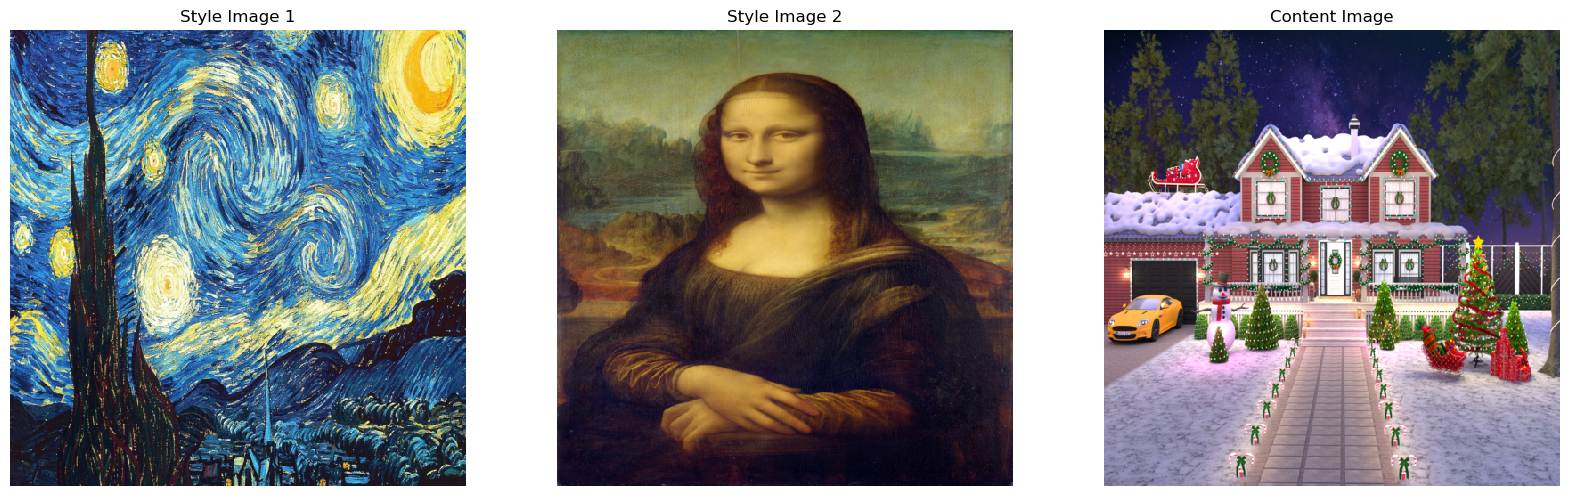

In [3]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

def get_image(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    return image

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
images = [style_img_1, style_img_2, content_img]
titles = ["Style Image 1", "Style Image 2", "Content Image"]
for i in range(3):
    img = get_image(images[i], titles[i])
    axs[i].imshow(img, interpolation='nearest')
    axs[i].set_title(titles[i])
    axs[i].axis('off')



In [16]:
torch.__version__

'2.0.1'

In [6]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [7]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

Now the style loss module looks almost exactly like the content loss
module. The style distance is also computed using the mean square
error between $G_{XL}$ and $G_{SL}$.




In [8]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [9]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Additionally, VGG networks are trained on images with each channel
normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
We will use them to normalize the image before sending it into the network.




In [10]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [11]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_imgs, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            style_loss = []
            for index, style_image in enumerate(style_imgs):
                target_feature = model(style_image).detach()
                style_loss_index = StyleLoss(target_feature)
                model.add_module("style_loss_{}_{}".format(i, index), style_loss_index)
                style_loss.append(style_loss_index)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Next, we select the input image. You can use a copy of the content image
or white noise.




In [13]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

Finally, we must define a function that performs the neural transfer. For
each iteration of the networks, it is fed an updated input and computes
new losses. We will run the ``backward`` methods of each loss module to
dynamically compute their gradients. The optimizer requires a “closure”
function, which reevaluates the module and returns the loss.

We still have one final constraint to address. The network may try to
optimize the input with values that exceed the 0 to 1 tensor range for
the image. We can address this by correcting the input values to be
between 0 to 1 each time the network is run.




In [14]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_imgs, style_coeffs, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_imgs, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers 
    # such as dropout or batch normalization layers behave correctly. 
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                for index, style_loss in enumerate(sl):
                    style_score += style_coeffs[index] * style_loss.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            # if run[0] % 50 == 0:
            #     print("run {}:".format(run))
            #     print('Style Loss : {:4f} Content Loss: {:4f}'.format(
            #         style_score.item(), content_score.item()))
            #     print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Finally, we can run the algorithm.




Building the style transfer model..


/home/a/anaconda3/envs/grinc/lib/python3.8/site-packages/torch/utils/_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing..
run [50]:
Style Loss : 4.136123 Content Loss: 4.210524

run [100]:
Style Loss : 1.150161 Content Loss: 3.048752

run [150]:
Style Loss : 0.725321 Content Loss: 2.668054

run [200]:
Style Loss : 0.485425 Content Loss: 2.505367

run [250]:
Style Loss : 0.351145 Content Loss: 2.416146

run [300]:
Style Loss : 0.270279 Content Loss: 2.358237



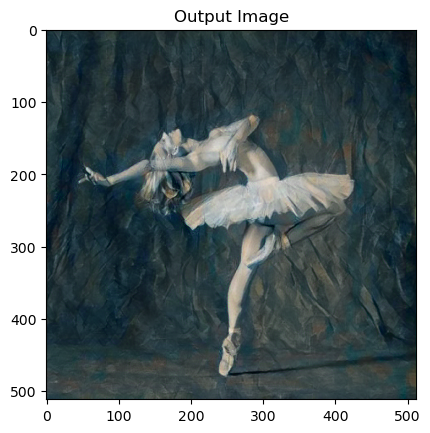

In [16]:
style_imgs = [style_img_1, style_img_2]
style_coeffs = [0.5, 0.5]
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_imgs, style_coeffs, input_img)

plt.figure()
output = output.cpu().clone()
output = output.squeeze(0)
output = unloader(output)
output = transforms.Resize((original_dim[1], original_dim[0]))(output)
plt.title("Stylized Image")
plt.imshow(output)
# remove ticks and axis
plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)


This method does work but doesn't scale. Johnson et al. overcame this by proposing a feedforward style transfer network, which is trained to go from content to stylized image in one pass. However, it is not directly applicable for our problem as the network is trained on a single style. 

# A LEARNED REPRESENTATION FOR ARTISTIC STYLE

Dumoulin et al. describe a method that easily scales to $N$-styles while still being fast.  A visual texture/style is conjectured to be spatially homogenous and consist of repeated structural motifs whose minimal sufficient statistics are captured by lower order statistical measurements.

Most important idea - Conditional Instance Normalization

Styles probably share some degree of computation e.g different art nay have similar paint strokes but differ in the color palette.

All convolutional weights of a style transfer network can be shared across many styles, and it is sufficient to tune parameters for an affine transformation after normalization for each style. Scaling and shifiting are the only requirements to condition on a specific style, after normalizing the layer’s activations $x$.  

$$z=\gamma_s\left(\frac{x-\mu}{\sigma}\right)+\beta_s$$

where $\mu$ and $\sigma$ are $x$'s mean and standard deviation across both the spatial axes.

### Pretrained model - Image Transform Net + VGG19

Image Transform Network is a feedforward style transfer network, which is trained to go from content to stylized image in one pass. VGG19 serves as loss function similar to the work 
of Gatys et al. 

##### Image Transform Network
Image Transform Network is a deep residual convolutional neural network. 

NameError: name 'image_loader' is not defined

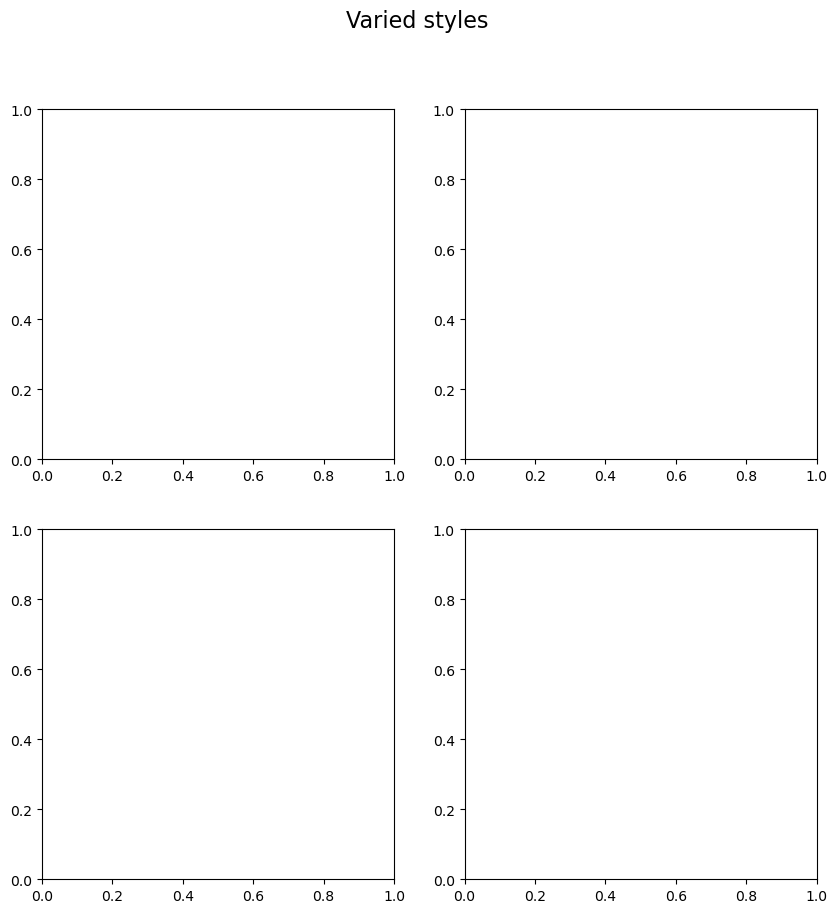

In [3]:
import matplotlib.pyplot as plt
images = ["edwin.jpg", "lautrec.jpg", "rouault.jpeg", "signac.jpg"]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# set title
fig.suptitle('Varied styles', fontsize=16)

index = 0
for i in range(2):
    for j in range(2):
        img = image_loader("images/" + images[index])
        img = get_image(img)
        axs[i, j].imshow(img, interpolation='nearest')
        name = images[index].split(".")[0]
        name = name.capitalize()
        axs[i, j].set_title(name)
        axs[i, j].axis('off')
        index += 1

# add caption
fig.text(0.5, 0.01, 'few of the varied styles', ha='center', fontsize=12);


In [4]:
import ast
import os
from skimage import io
import numpy as np
import tensorflow.compat.v1 as tf
from icecream import ic
import matplotlib.pyplot as plt

from image_stylization import image_utils, model, ops

import numpy as np


def create_style(n=10, distrib=None):
    if distrib is None:
        distrib = np.random.rand(n)
    distrib = distrib / np.sum(distrib)
    styles = {}
    for i in range(n):
        styles[i] = distrib[i]
    return styles



def _load_checkpoint(sess, checkpoint):
    """Loads a checkpoint file into the session."""
    model_saver = tf.train.Saver(tf.global_variables())
    checkpoint = os.path.expanduser(checkpoint)
    if tf.gfile.IsDirectory(checkpoint):
        checkpoint = tf.train.latest_checkpoint(checkpoint)
        tf.logging.info("loading latest checkpoint file: {}".format(checkpoint))
    model_saver.restore(sess, checkpoint)


def _describe_style(which_styles):
    """Returns a string describing a linear combination of styles."""

    def _format(v):
        formatted = str(int(round(v * 1000.0)))
        while len(formatted) < 3:
            formatted = "0" + formatted
        return formatted

    values = []
    for k in sorted(which_styles.keys()):
        values.append("%s_%s" % (k, _format(which_styles[k])))
    return "_".join(values)


def _style_mixture(which_styles, num_styles):
    """Returns a 1-D array mapping style indexes to weights."""
    if not isinstance(which_styles, dict):
        raise ValueError("Style mixture must be a dictionary.")
    mixture = np.zeros([num_styles], dtype=np.float32)
    for index in which_styles:
        mixture[index] = which_styles[index]
    return mixture



def _multiple_styles(input_image, which_styles, output_dir, checkpoint, output_basename, num_styles=10, alpha=1.0):
    """Stylizes image into a linear combination of styles and writes to disk."""
    with tf.Graph().as_default(), tf.Session() as sess:
        mixture = _style_mixture(which_styles, num_styles)
        stylized_images = model.transform(
            input_image,
            alpha=alpha,
            normalizer_fn=ops.weighted_instance_norm,
            normalizer_params={
                "weights": tf.constant(mixture),
                "num_categories": num_styles,
                "center": True,
                "scale": True,
            },
        )
        _load_checkpoint(sess, checkpoint)

        stylized_image = stylized_images.eval()

        image = np.uint8(stylized_image * 255.0)
        plt.imshow(np.squeeze(image, 0), interpolation='nearest')

            
        image_utils.save_np_image(
            stylized_image,
            os.path.join(
                output_dir,
                "%s_%s.png" % (output_basename, _describe_style(which_styles)),
            ),
        )

tf.disable_v2_behavior()
input_image = "images/Masterlayer_Event221_SetA.png"
checkpoint = "image_stylization/multistyle-pastiche-generator-varied.ckpt"
output_basename = "all_monet_styles"
output_dir = "output"
image = np.expand_dims(
    image_utils.load_np_image(os.path.expanduser(input_image)), 0
)

output_dir = os.path.expanduser(output_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
num_styles = 32
which_styles =  create_style(32)
_multiple_styles(image, which_styles, output_dir, checkpoint, output_basename, num_styles)


ModuleNotFoundError: No module named 'skimage'

In [ ]:
distrib = np.zeros(32)
distrib[5] = 1
which_styles =  create_style(32, distrib)
which_styles

# How to combine the styles?

There is a huge number of combinations of styles we could try. We can narrow down to a few painting/artworks for the styles, but deciding what weights to give them can become intractable. Few of them will be useful and aesthetically pleasing. We can only recognize the desired behavior, but not necessarily demonstrate it. It motivates the application of reinforcement learning.

# Reinforcement Learning with Human Feedback

Introduced by OpenAI, We could leverage human feedback to learn a reward model which assigns a reward to any particular weights distribution vector. Then use any suitable RL algorithm to find the optimal set of weights.

#### Steps
1. Present pair of images, the human labeler will choose a winner from them. We would construct training dataset in the form of $(v_w, v_l)$ where $v_w$ corresponds to the weight distribution vector of the winning image and $v_l$ is the weight distribution vector of the losing image.
2. Learn the reward model $r_\phi$
    For each training sample  $(v_w, v_l)$,
    -   


sourcwe - https://huyenchip.com/2023/05/02/rlhf.html#phase_3_rlhf


# How to combine the styles?

There is a huge number of combinations of styles we could try. We can narrow down to a few painting/artworks for the styles, but deciding what weights to give them can become intractable. Few of them will be useful and aesthetically pleasing. We can only recognize the desired behavior, but not necessarily demonstrate it. It motivates the application of reinforcement learning.

## Reinforcement Learning with Human Feedback

Introduced by OpenAI, we could leverage human feedback to learn a reward model which assigns a reward to any particular weights distribution vector. Then use any suitable RL algorithm to find the optimal set of weights.

### Steps
1. Present a pair of images, and the human labeler will choose a winner from them. We would construct a training dataset in the form of $(v_w, v_l)$ where $v_w$ corresponds to the weight distribution vector of the winning image and $v_l$ is the weight distribution vector of the losing image.
2. Learn the reward model $r_\phi$. For each training sample $(v_w, v_l)$,
    - Use a neural network to predict the reward $r_\phi(v_w)$ for the winning image.
    - Use a neural network to predict the reward $r_\phi(v_l)$ for the losing image.
    - Update the parameters of the reward model using the difference between the predicted rewards and the true reward of 1 for the winning image and 0 for the losing image.
3. Use 

This approach demonstrates the potential of using human feedback to guide the learning process in reinforcement learning, particularly in the context of image style transfer.

Citations:
[1] https://huyenchip.com/2023/05/02/rlhf.html#phase_3_rlhf

SyntaxError: invalid syntax (688677740.py, line 3)